<a href="https://colab.research.google.com/github/diegomrodrigues/generative_models_experiments/blob/main/Variational%20Auto-encoder%20Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import numpy as np
import os
import shutil
import sys
import torch
import os
import pickle
from torch.nn import functional as F
from torchvision import datasets, transforms

################################################################################
# Please familiarize yourself with the code below.
#
# Note that the notation is
# argument: argument_type: argument_shape
#
# Furthermore, the expected argument_shape is only a guideline. You're free to
# pass in inputs that violate the expected argument_shape provided you know
# what you're doing
################################################################################

def sample_gaussian(m, v):
    """
    Element-wise application reparameterization trick to sample from Gaussian

    Args:
        m: tensor: (batch, ...): Mean
        v: tensor: (batch, ...): Variance

    Return:
        z: tensor: (batch, dim): Samples
    """
    ### START CODE HERE ###
    std = torch.sqrt(v)
    eps = torch.randn_like(std)
    z = m + std * eps
    return z
    ### END CODE HERE ###


def log_normal(x, m, v):
    """
    Computes the element-wise log probability of a Gaussian and then sums over the
    last dimension. We're assuming all dimensions are batch dimensions except for the
    last dimension.

    Args:
        x: tensor of shape (..., dim): Observation
        m: tensor of shape (..., dim): Mean
        v: tensor of shape (..., dim): Variance

    Returns:
        log_prob: tensor of shape (...): Log probability of each sample. The summation
            over the last dimension is performed, so the last dimension is reduced.
    """
    ################################################################################
    # Compute element-wise log probability of normal and remember to sum over
    # the last dimension
    ################################################################################
    ### START CODE HERE ###
    import torch

    # Compute the squared difference divided by variance
    diff = x - m
    exp_term = (diff ** 2) / v

    # Compute the log term: log(2 * pi * v)
    log_var_term = torch.log(2 * torch.pi * v)

    # Sum over the last dimension
    log_prob = -0.5 * (exp_term + log_var_term).sum(dim=-1)
    ### END CODE HERE ###
    ################################################################################
    # End of code modification
    ################################################################################
    return log_prob


def log_normal_mixture(z, m, v):
    """
    Computes log probability of a Gaussian mixture.

    Args:
        z: tensor of shape (batch, dim): Observations
        m: tensor of shape (batch, mix, dim): Mixture means
        v: tensor of shape (batch, mix, dim): Mixture variances

    Returns:
        log_prob: tensor of shape (batch,): Log probability of each sample
    """
    ################################################################################
    # Compute the uniformly-weighted mixture of Gaussians density for each sample
    # in the batch
    ################################################################################
    ### START CODE HERE ###
    import torch

    # z: (batch, dim)
    # m: (batch, mix, dim)
    # v: (batch, mix, dim)

    # Expand z to (batch, 1, dim) to match the shape of m and v
    z_expanded = z.unsqueeze(1)  # Now z_expanded is (batch, 1, dim)

    # Compute log probabilities for each mixture component
    log_probs = log_normal(z_expanded, m, v)  # Shape: (batch, mix)

    # Since the mixture weights are uniform, the log weight is -log(k)
    mix = m.size(1)  # Number of mixture components
    log_weight = -torch.log(torch.tensor(mix, dtype=z.dtype, device=z.device))

    # Compute the log probability of the mixture
    # Apply log-sum-exp over the mixture components
    log_prob = torch.logsumexp(log_probs + log_weight, dim=1)  # Shape: (batch,)
    ### END CODE HERE ###
    ################################################################################
    # End of code modification
    ################################################################################
    return log_prob


def gaussian_parameters(h, dim=-1):
    """
    Converts generic real-valued representations into mean and variance
    parameters of a Gaussian distribution

    Args:
        h: tensor: (batch, ..., dim, ...): Arbitrary tensor
        dim: int: (): Dimension along which to split the tensor for mean and
            variance

    Returns:
        m: tensor: (batch, ..., dim / 2, ...): Mean
        v: tensor: (batch, ..., dim / 2, ...): Variance
    """
    m, h = torch.split(h, h.size(dim) // 2, dim=dim)
    v = F.softplus(h) + 1e-8
    return m, v


def log_bernoulli_with_logits(x, logits):
    """
    Computes the log probability of a Bernoulli given its logits

    Args:
        x: tensor: (batch, dim): Observation
        logits: tensor: (batch, dim): Bernoulli logits

    Return:
        log_prob: tensor: (batch,): log probability of each sample
    """
    bce = torch.nn.BCEWithLogitsLoss(reduction='none')
    log_prob = -bce(input=logits, target=x).sum(-1)
    return log_prob


def kl_cat(q, log_q, log_p):
    """
    Computes the KL divergence between two categorical distributions

    Args:
        q: tensor: (batch, dim): Categorical distribution parameters
        log_q: tensor: (batch, dim): Log of q
        log_p: tensor: (batch, dim): Log of p

    Return:
        kl: tensor: (batch,) kl between each sample
    """
    element_wise = (q * (log_q - log_p))
    kl = element_wise.sum(-1)
    return kl


def kl_normal(qm, qv, pm, pv):
    """
    Computes the elem-wise KL divergence between two normal distributions KL(q || p) and
    sum over the last dimension

    Args:
        qm: tensor: (batch, dim): q mean
        qv: tensor: (batch, dim): q variance
        pm: tensor: (batch, dim): p mean
        pv: tensor: (batch, dim): p variance

    Return:
        kl: tensor: (batch,): kl between each sample
    """
    element_wise = 0.5 * (torch.log(pv) - torch.log(qv) + qv / pv + (qm - pm).pow(2) / pv - 1)
    kl = element_wise.sum(-1)
    return kl


def duplicate(x, rep):
    """
    Duplicates x along dim=0

    Args:
        x: tensor: (batch, ...): Arbitrary tensor
        rep: int: (): Number of replicates. Setting rep=1 returns orignal x

    Returns:
        _: tensor: (batch * rep, ...): Arbitrary replicated tensor
    """
    return x.expand(rep, *x.shape).reshape(-1, *x.shape[1:]).to(x.device)


def log_mean_exp(x, dim):
    """
    Compute the log(mean(exp(x), dim)) in a numerically stable manner

    Args:
        x: tensor: (...): Arbitrary tensor
        dim: int: (): Dimension along which mean is computed

    Return:
        _: tensor: (...): log(mean(exp(x), dim))
    """
    return log_sum_exp(x, dim) - np.log(x.size(dim))


def log_sum_exp(x, dim=0):
    """
    Compute the log(sum(exp(x), dim)) in a numerically stable manner

    Args:
        x: tensor: (...): Arbitrary tensor
        dim: int: (): Dimension along which sum is computed

    Return:
        _: tensor: (...): log(sum(exp(x), dim))
    """
    max_x = torch.max(x, dim)[0]
    new_x = x - max_x.unsqueeze(dim).expand_as(x)
    return max_x + (new_x.exp().sum(dim)).log()


def load_model_by_name(model, global_step, device=None):
    """
    Load a model based on its name model.name and the checkpoint iteration step

    Args:
        model: Model: (): A model
        global_step: int: (): Checkpoint iteration
    """
    file_path = os.path.join('checkpoints',
                             model.name,
                             'model-{:05d}.pt'.format(global_step))
    state = torch.load(file_path, map_location=device)
    try:
        model.load_state_dict(state)
        print("Loaded from {}".format(file_path))
    except:
        pass

import torch
import os
from torch import nn

class Encoder(nn.Module):
    def __init__(self, z_dim, y_dim=0):
        super().__init__()
        self.z_dim = z_dim
        self.y_dim = y_dim
        self.net = nn.Sequential(
            nn.Linear(784 + y_dim, 300),
            nn.ELU(),
            nn.Linear(300, 300),
            nn.ELU(),
            nn.Linear(300, 2 * z_dim),
        )

    def forward(self, x, y=None):
        xy = x if y is None else torch.cat((x, y), dim=1)
        h = self.net(xy)
        m, v = ut.gaussian_parameters(h, dim=1)
        return m, v

class Decoder(nn.Module):
    def __init__(self, z_dim, y_dim=0):
        super().__init__()
        self.z_dim = z_dim
        self.y_dim = y_dim
        self.net = nn.Sequential(
            nn.Linear(z_dim + y_dim, 300),
            nn.ELU(),
            nn.Linear(300, 300),
            nn.ELU(),
            nn.Linear(300, 784)
        )

    def forward(self, z, y=None):
        zy = z if y is None else torch.cat((z, y), dim=1)
        return self.net(zy)

class Classifier(nn.Module):
    def __init__(self, y_dim):
        super().__init__()
        self.y_dim = y_dim
        self.net = nn.Sequential(
            nn.Linear(784, 300),
            nn.ReLU(),
            nn.Linear(300, 300),
            nn.ReLU(),
            nn.Linear(300, y_dim)
        )

    def forward(self, x):
        return self.net(x)

import numpy as np
import torch
import os
from torch import nn

class GMVAE(nn.Module):
    def __init__(self, nn='v1', z_dim=2, k=500, name='gmvae'):
        super().__init__()
        self.name = name
        self.k = k
        self.z_dim = z_dim
        nn = getattr(nns, nn)
        self.enc = nn.Encoder(self.z_dim) # from ./nns/v1.py
        self.dec = nn.Decoder(self.z_dim) # from ./nns/v1.py

        # Mixture of Gaussians prior
        self.z_pre = torch.nn.Parameter(torch.randn(1, 2 * self.k, self.z_dim)
                                        / np.sqrt(self.k * self.z_dim))
        # Uniform weighting
        self.pi = torch.nn.Parameter(torch.ones(k) / k, requires_grad=False)

    def negative_elbo_bound(self, x):
        """
        Computes the Evidence Lower Bound, KL, and Reconstruction costs

        Args:
            x: tensor: (batch, dim): Observations

        Returns:
            nelbo: tensor: (): Negative evidence lower bound
            kl: tensor: (): ELBO KL divergence to prior
            rec: tensor: (): ELBO Reconstruction term
        """
        ################################################################################
        # We provide the learnable prior for you. Familiarize yourself with
        # this object by checking its shape.
        prior = ut.gaussian_parameters(self.z_pre, dim=1)
        ### START CODE HERE ###
        import torch.nn.functional as F

        # Encode x to get the parameters of q(z|x)
        m_q, v_q = self.enc(x)

        # Sample z ~ q(z|x) using the reparameterization trick
        z = ut.sample_gaussian(m_q, v_q)  # Shape: (batch, z_dim)

        # Decode z to get logits for p(x|z)
        logits = self.dec(z)  # Shape: (batch, dim)

        # Compute Reconstruction Loss (Negative Log-Likelihood)
        # For Bernoulli likelihood, use binary cross-entropy loss
        rec = F.binary_cross_entropy_with_logits(logits, x, reduction='sum') / x.size(0)
        # Alternatively, you can use 'mean' reduction without dividing by batch size
        # rec = F.binary_cross_entropy_with_logits(logits, x, reduction='mean')

        # Compute log q(z|x)
        log_q_zx = ut.log_normal(z, m_q, v_q)  # Shape: (batch,)

        # Compute log p(z) using the mixture of Gaussians prior
        m_p, v_p = prior  # Each of shape (1, k, z_dim)
        batch_size = x.size(0)
        m_p = m_p.expand(batch_size, -1, -1)  # Shape: (batch, k, z_dim)
        v_p = v_p.expand(batch_size, -1, -1)  # Shape: (batch, k, z_dim)

        # Compute log p(z) as log of the mixture density
        log_p_z = ut.log_normal_mixture(z, m_p, v_p)  # Shape: (batch,)

        # Compute KL divergence approximation
        kl_z = (log_q_zx - log_p_z).mean()

        # Compute Negative ELBO
        nelbo = kl_z + rec
        ### END CODE HERE ###
        ################################################################################
        return nelbo, kl_z, rec

    def negative_iwae_bound(self, x, iw):
        """
        Computes the Importance Weighted Autoencoder Bound
        Additionally, we also compute the ELBO KL and reconstruction terms

        Args:
            x: tensor: (batch, dim): Observations
            iw: int: (): Number of importance weighted samples

        Returns:
            niwae: tensor: (): Negative IWAE bound
            kl: tensor: (): ELBO KL divergence to prior
            rec: tensor: (): ELBO Reconstruction term
        """
        ################################################################################
        # TODO: Modify/complete the code here
        # Compute niwae (negative IWAE) with iw importance samples, and the KL
        # and Rec decomposition of the Evidence Lower Bound
        #
        # Outputs should all be tensor scalars
        #
        # Return:
        #   niwae, kl, rec
        ################################################################################
        # We provide the learnable prior for you. Familiarize yourself with
        # this object by checking its shape.
        prior = ut.gaussian_parameters(self.z_pre, dim=1)
        ### START CODE HERE ###
        ### END CODE HERE ###
        ################################################################################
        # End of code modification
        ################################################################################
        raise NotImplementedError

    def loss(self, x):
        nelbo, kl, rec = self.negative_elbo_bound(x)
        loss = nelbo

        summaries = dict((
            ('train/loss', nelbo),
            ('gen/elbo', -nelbo),
            ('gen/kl_z', kl),
            ('gen/rec', rec),
        ))

        return loss, summaries

    def sample_sigmoid(self, batch):
        z = self.sample_z(batch)
        return self.compute_sigmoid_given(z)

    def compute_sigmoid_given(self, z):
        logits = self.dec(z)
        return torch.sigmoid(logits)

    def sample_z(self, batch):
        m, v = ut.gaussian_parameters(self.z_pre.squeeze(0), dim=0)
        idx = torch.distributions.categorical.Categorical(self.pi).sample((batch,))
        m, v = m[idx], v[idx]
        return ut.sample_gaussian(m, v)

    def sample_x(self, batch):
        z = self.sample_z(batch)
        return self.sample_x_given(z)

    def sample_x_given(self, z):
        return torch.bernoulli(self.compute_sigmoid_given(z))

import torch
from torch import nn
import os

class VAE(nn.Module):
    def __init__(self, nn='v1', name='vae', z_dim=2):
        super().__init__()
        self.name = name
        self.z_dim = z_dim
        nn = getattr(nns, nn)
        self.enc = nn.Encoder(self.z_dim) # from ./nns/v1.py
        self.dec = nn.Decoder(self.z_dim) # from ./nns/v1.py

        # Set prior as fixed parameter attached to Module
        self.z_prior_m = torch.nn.Parameter(torch.zeros(1), requires_grad=False)
        self.z_prior_v = torch.nn.Parameter(torch.ones(1), requires_grad=False)
        self.z_prior = (self.z_prior_m, self.z_prior_v)

    def negative_elbo_bound(self, x):
        """
        Computes the Evidence Lower Bound, KL and, Reconstruction costs

        Args:
            x: tensor: (batch, dim): Observations

        Returns:
            nelbo: tensor: (): Negative evidence lower bound
            kl: tensor: (): ELBO KL divergence to prior
            rec: tensor: (): ELBO Reconstruction term
        """
        ### START CODE HERE ###
        # Encode x to get parameters of q(z|x)
        m, v = self.enc(x)  # m and v are tensors of shape (batch_size, z_dim)

        # Sample z ~ q(z|x)
        z = sample_gaussian(m, v)

        # Compute KL divergence between q(z|x) and p(z)
        kl = ut.kl_normal(m, v, self.z_prior_m.expand_as(m), self.z_prior_v.expand_as(v))
        kl = kl.mean()  # Mean over batch

        # Compute reconstruction loss
        logits = self.dec(z)  # Shape: (batch_size, data_dim)
        rec = torch.nn.functional.binary_cross_entropy_with_logits(
            logits, x, reduction='none'
        )
        rec = rec.sum(dim=1)  # Sum over data dimensions
        rec = rec.mean()  # Mean over batch

        # Negative ELBO
        nelbo = kl + rec

        return nelbo, kl, rec
        ### END CODE HERE ###

    def negative_iwae_bound(self, x, iw):
        """
        Computes the Importance Weighted Autoencoder Bound
        Additionally, we also compute the ELBO KL and reconstruction terms

        Args:
            x: tensor: (batch, dim): Observations
            iw: int: (): Number of importance weighted samples

        Returns:
            niwae: tensor: (): Negative IWAE bound
            kl: tensor: (): ELBO KL divergence to prior
            rec: tensor: (): ELBO Reconstruction term
        """
        ### START CODE HERE ###
        batch_size, data_dim = x.shape

        # Encode x to get parameters of q(z|x)
        m, v = self.enc(x)  # (batch_size, z_dim)

        # Expand m and v to (batch_size, iw, z_dim)
        m_expanded = m.unsqueeze(1).expand(batch_size, iw, self.z_dim)
        v_expanded = v.unsqueeze(1).expand(batch_size, iw, self.z_dim)

        # Sample z ~ q(z|x), iw samples
        epsilon = torch.randn(batch_size, iw, self.z_dim, device=x.device)
        z = m_expanded + torch.sqrt(v_expanded) * epsilon  # (batch_size, iw, z_dim)

        # Compute log p(z)
        log_pz = ut.log_normal(z, torch.zeros_like(z), torch.ones_like(z))  # (batch_size, iw)

        # Compute log q(z|x)
        log_qz_given_x = ut.log_normal(z, m_expanded, v_expanded)  # (batch_size, iw)

        # Decode z to get logits
        z_flat = z.view(-1, self.z_dim)  # (batch_size * iw, z_dim)
        logits = self.dec(z_flat)  # (batch_size * iw, data_dim)
        logits = logits.view(batch_size, iw, data_dim)  # (batch_size, iw, data_dim)

        # Expand x to match z
        x_expanded = x.unsqueeze(1).expand(batch_size, iw, data_dim)  # (batch_size, iw, data_dim)

        # Compute log p(x|z)
        log_px_given_z = ut.log_bernoulli_with_logits(x_expanded, logits)  # (batch_size, iw)

        # Compute log w = log p(x,z) - log q(z|x)
        log_w = log_pz + log_px_given_z - log_qz_given_x  # (batch_size, iw)

        # Compute negative IWAE bound
        log_mean_w = ut.log_mean_exp(log_w, dim=1)  # (batch_size,)
        niwae = -torch.mean(log_mean_w)  # Scalar

        # Compute KL divergence for ELBO
        kl = ut.kl_normal(m, v, torch.zeros_like(m), torch.ones_like(v))  # (batch_size,)
        kl = torch.mean(kl)

        # Compute reconstruction loss for ELBO
        z_rec = ut.sample_gaussian(m, v)  # (batch_size, z_dim)
        logits_rec = self.dec(z_rec)  # (batch_size, data_dim)
        rec = torch.nn.functional.binary_cross_entropy_with_logits(
            logits_rec, x, reduction='none'
        )
        rec = rec.sum(dim=1)  # (batch_size,)
        rec = torch.mean(rec)
        ### END CODE HERE ###
        return niwae, kl, rec



    def loss(self, x):
        nelbo, kl, rec = self.negative_elbo_bound(x)
        loss = nelbo

        summaries = dict((
            ('train/loss', nelbo),
            ('gen/elbo', -nelbo),
            ('gen/kl_z', kl),
            ('gen/rec', rec),
        ))

        return loss, summaries

    def sample_sigmoid(self, batch):
        z = self.sample_z(batch)
        return self.compute_sigmoid_given(z)

    def compute_sigmoid_given(self, z):
        logits = self.dec(z)
        return torch.sigmoid(logits)

    def sample_z(self, batch):
        return ut.sample_gaussian(
            self.z_prior[0].expand(batch, self.z_dim),
            self.z_prior[1].expand(batch, self.z_dim))

    def sample_x(self, batch):
        z = self.sample_z(batch)
        return self.sample_x_given(z)

    def sample_x_given(self, z):
        return torch.bernoulli(self.compute_sigmoid_given(z))


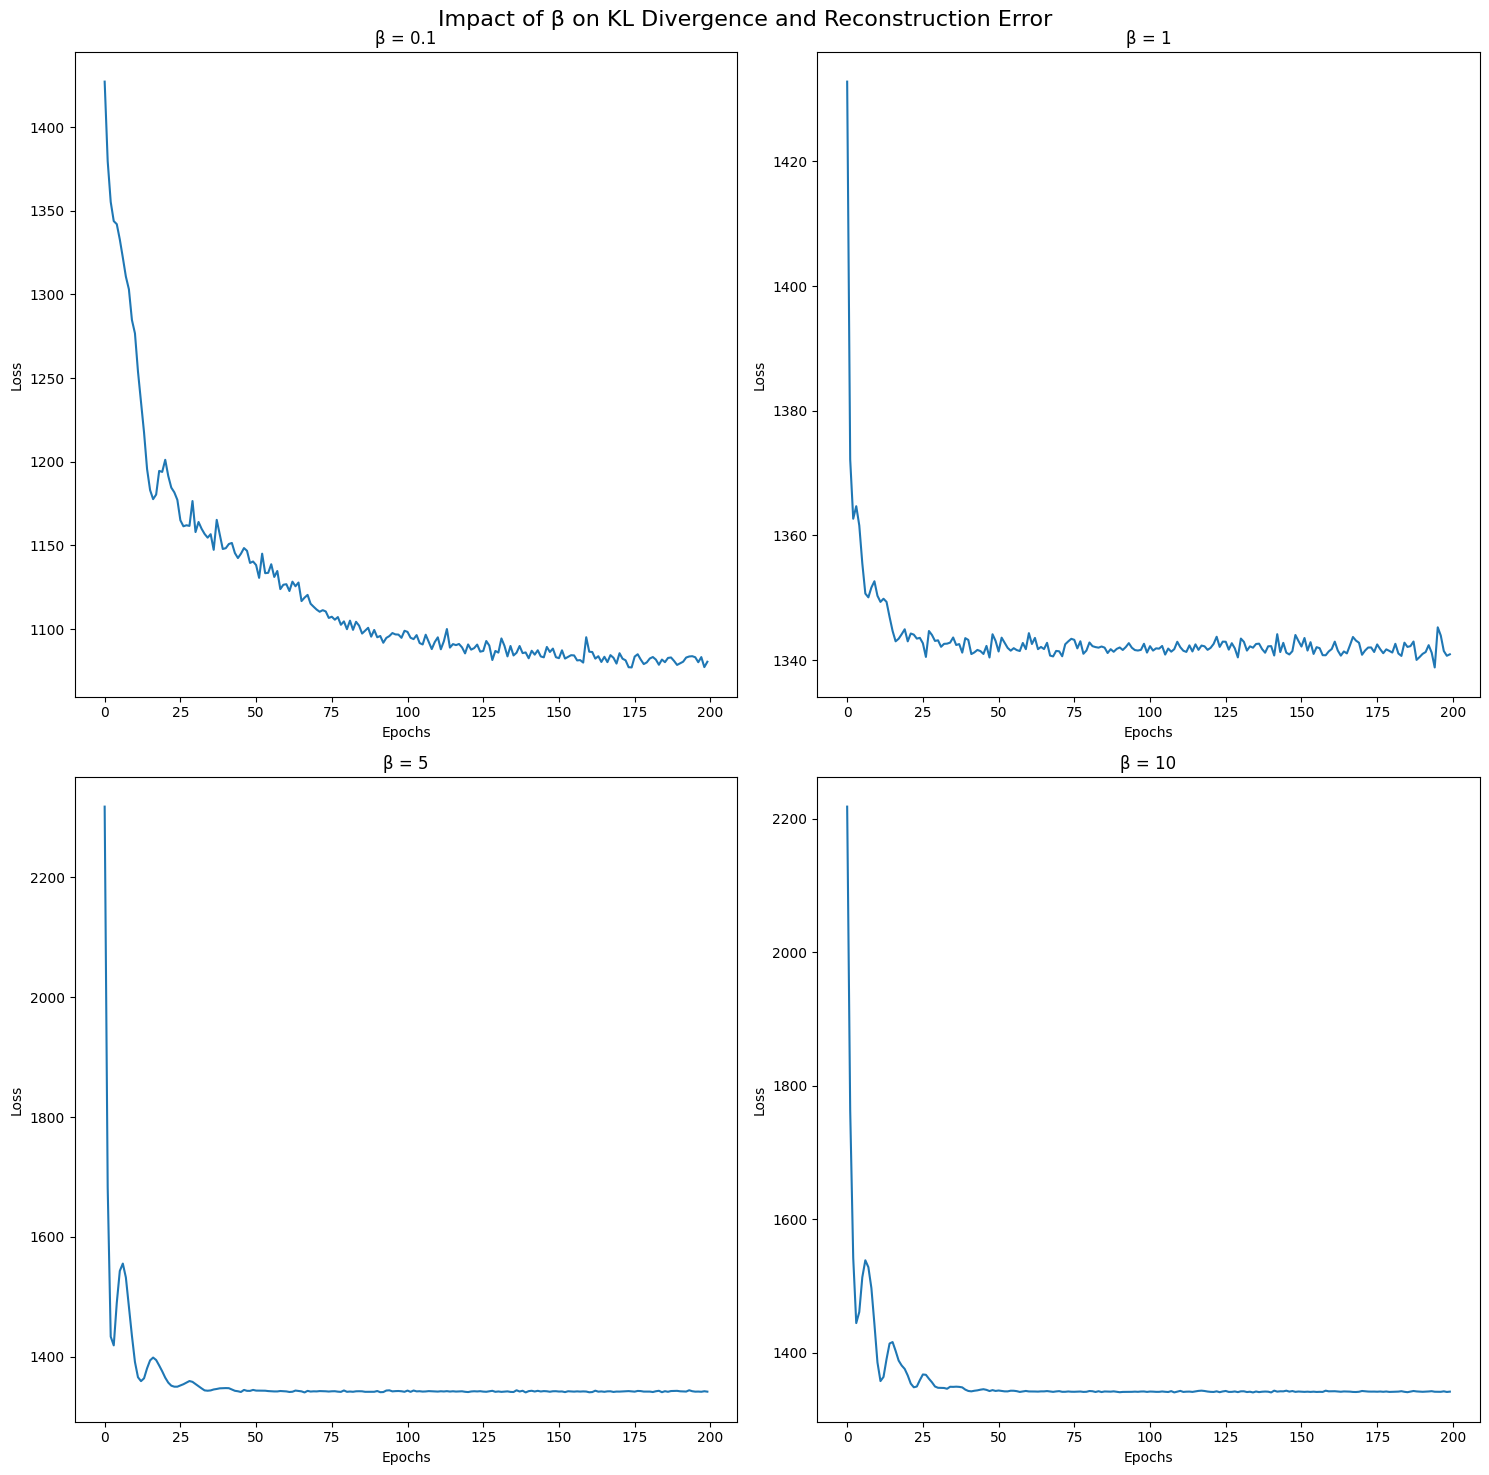

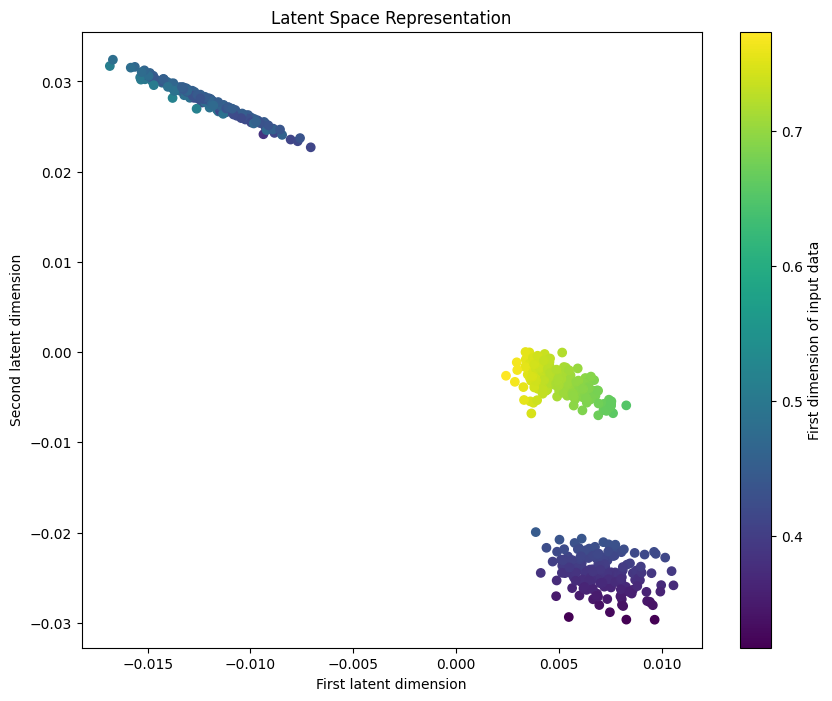

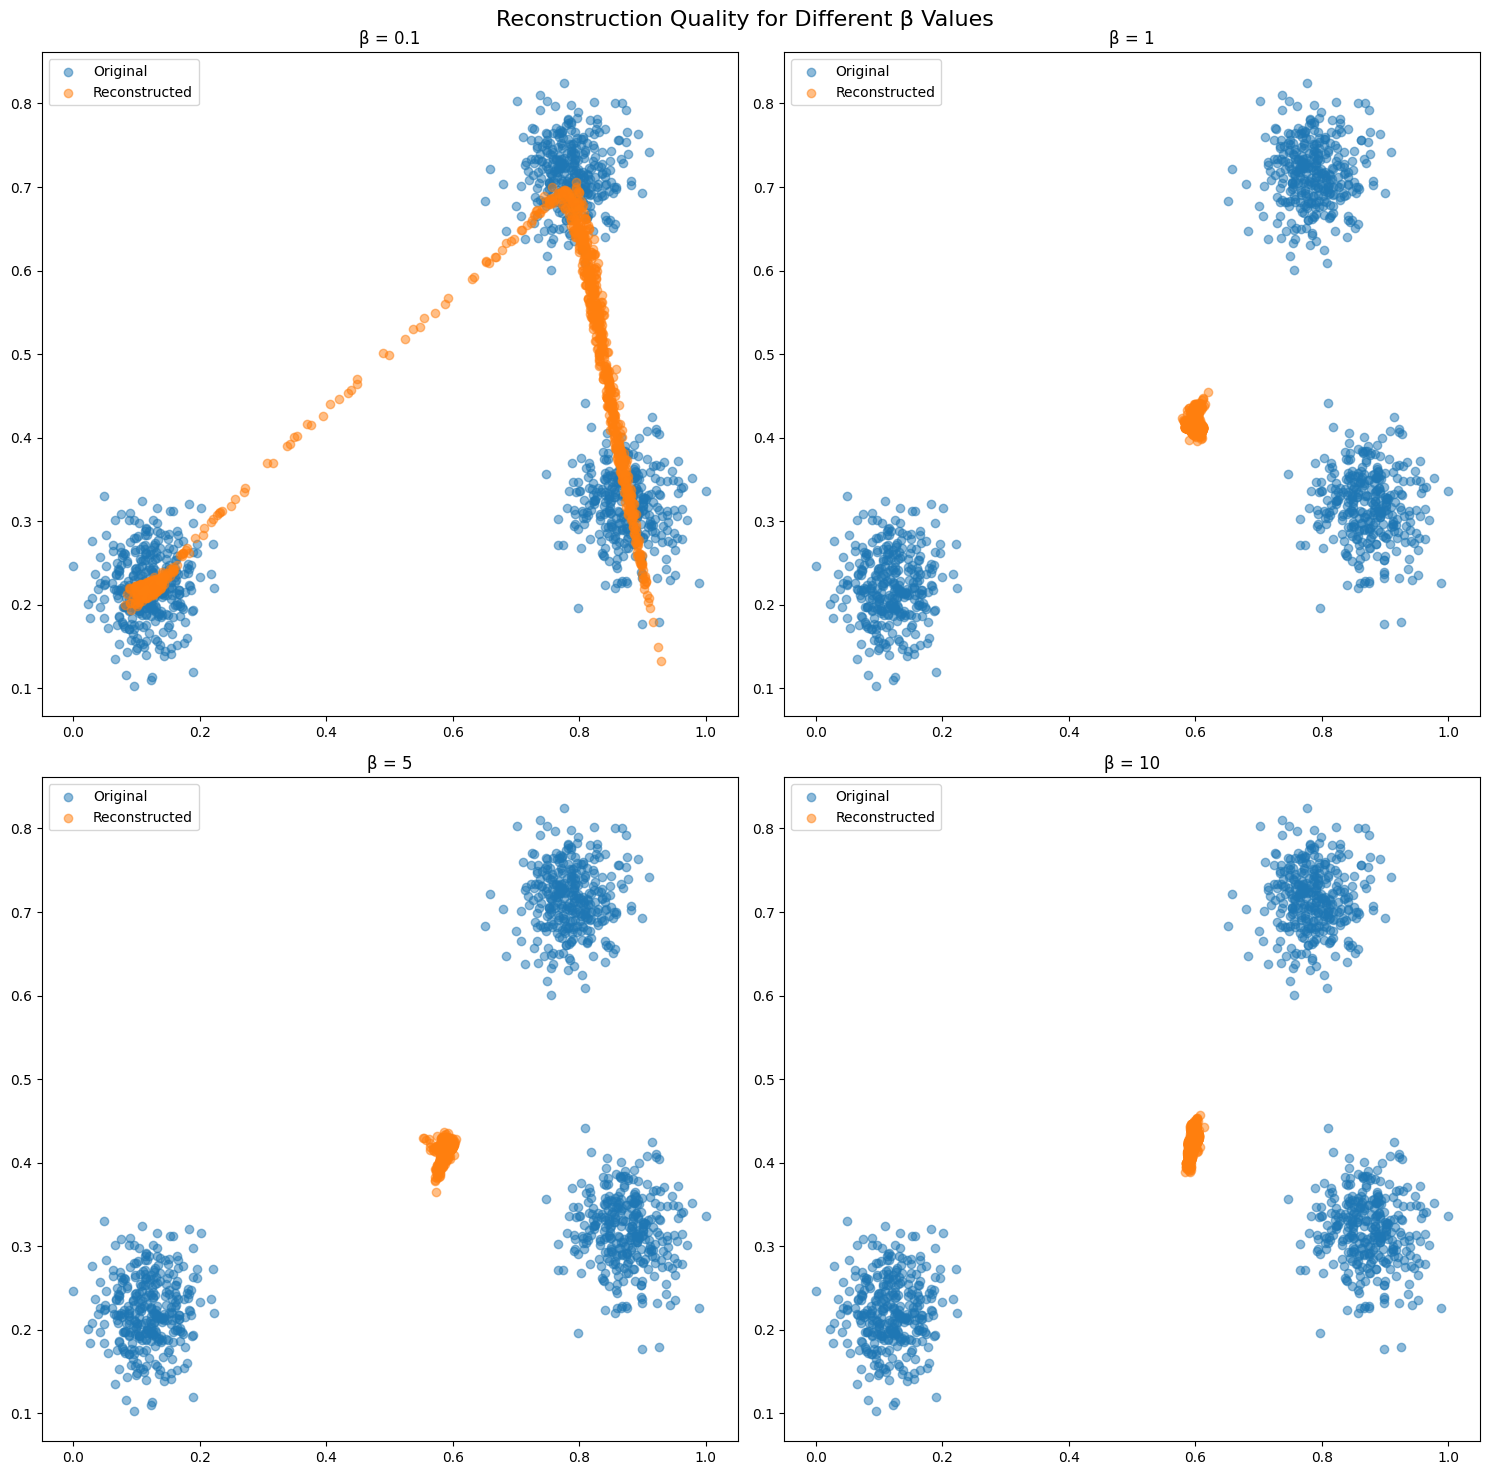

RuntimeError: shape '[10, 10]' is invalid for input of size 2

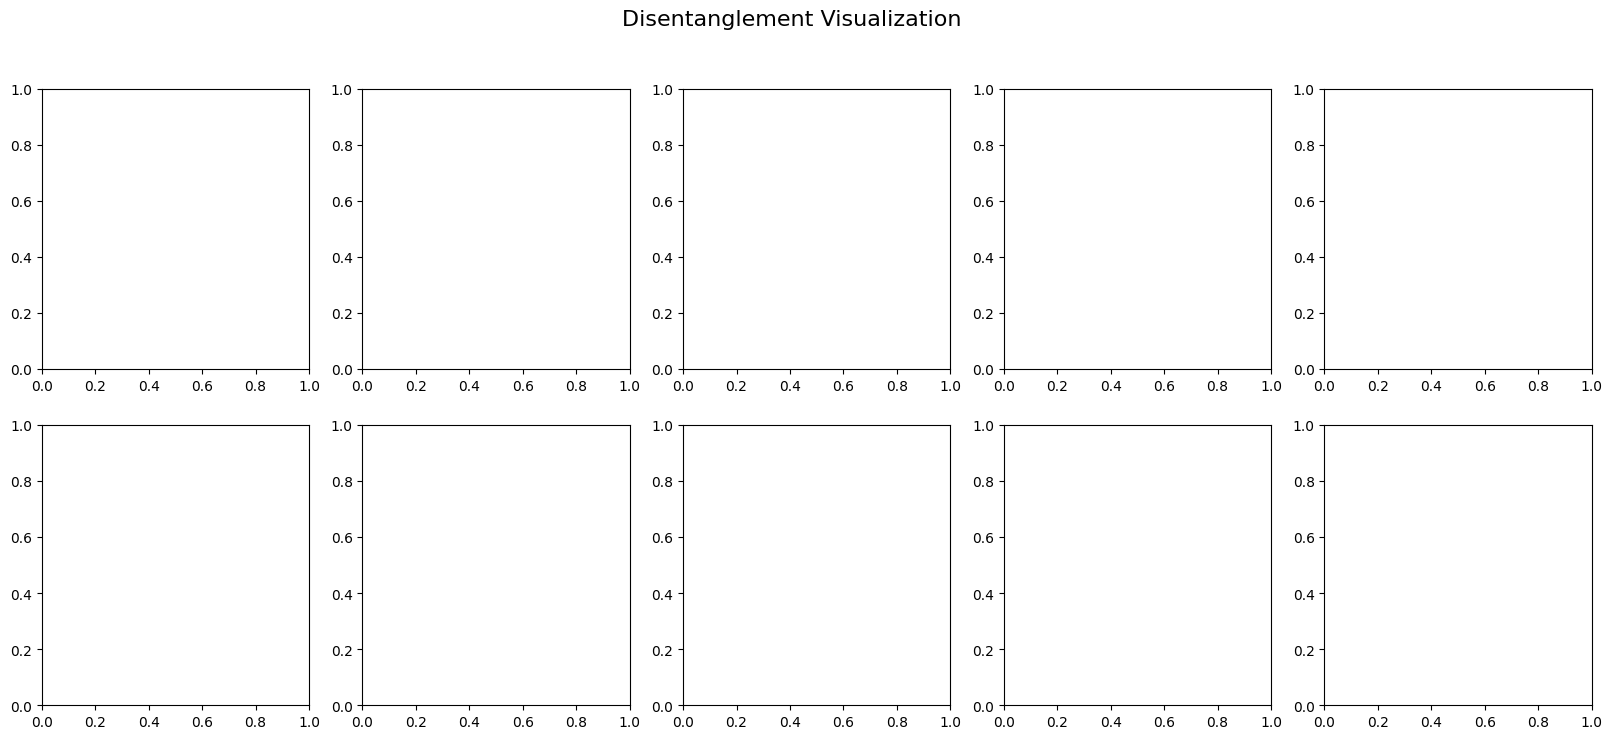

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal, kl_divergence
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define a simple VAE model
class SimpleVAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(SimpleVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim * 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, log_var = torch.chunk(h, 2, dim=-1)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

# Function to compute β-VAE loss
def beta_vae_loss(recon_x, x, mu, log_var, beta):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + beta * KLD

# Generate synthetic data
def generate_data(n_samples=1000, n_features=2, n_centers=3):
    X, _ = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_centers, cluster_std=0.5)
    X = (X - X.min()) / (X.max() - X.min())  # Normalize to [0, 1]
    return torch.FloatTensor(X)

# Training function
def train_vae(model, data, optimizer, beta, epochs=100):
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(data)
        loss = beta_vae_loss(recon_batch, data, mu, log_var, beta)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

# Visualization 1: Impact of β on KL Divergence and Reconstruction Error
def plot_beta_impact():
    betas = [0.1, 1, 5, 10]
    data = generate_data()

    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    fig.suptitle("Impact of β on KL Divergence and Reconstruction Error", fontsize=16)

    for i, beta in enumerate(betas):
        model = SimpleVAE(2, 2)
        optimizer = optim.Adam(model.parameters(), lr=0.01)
        losses = train_vae(model, data, optimizer, beta, epochs=200)

        ax = axes[i // 2, i % 2]
        ax.plot(losses)
        ax.set_title(f"β = {beta}")
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Loss")

    plt.tight_layout()
    plt.show()

# Visualization 2: Latent Space Visualization
def plot_latent_space():
    data = generate_data(n_samples=500)
    model = SimpleVAE(2, 2)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    train_vae(model, data, optimizer, beta=1, epochs=200)

    with torch.no_grad():
        mu, _ = model.encode(data)

    plt.figure(figsize=(10, 8))
    plt.scatter(mu[:, 0], mu[:, 1], c=data[:, 0], cmap='viridis')
    plt.colorbar(label='First dimension of input data')
    plt.title("Latent Space Representation")
    plt.xlabel("First latent dimension")
    plt.ylabel("Second latent dimension")
    plt.show()

# Visualization 3: Reconstruction Quality for Different β Values
def plot_reconstruction_quality():
    betas = [0.1, 1, 5, 10]
    data = generate_data()

    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    fig.suptitle("Reconstruction Quality for Different β Values", fontsize=16)

    for i, beta in enumerate(betas):
        model = SimpleVAE(2, 2)
        optimizer = optim.Adam(model.parameters(), lr=0.01)
        train_vae(model, data, optimizer, beta, epochs=200)

        with torch.no_grad():
            recon, _, _ = model(data)

        ax = axes[i // 2, i % 2]
        ax.scatter(data[:, 0], data[:, 1], label='Original', alpha=0.5)
        ax.scatter(recon[:, 0], recon[:, 1], label='Reconstructed', alpha=0.5)
        ax.set_title(f"β = {beta}")
        ax.legend()

    plt.tight_layout()
    plt.show()

# Visualization 4: Disentanglement Visualization
def plot_disentanglement():
    model = SimpleVAE(2, 2)
    data = generate_data()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    train_vae(model, data, optimizer, beta=5, epochs=200)

    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    fig.suptitle("Disentanglement Visualization", fontsize=16)

    z = torch.zeros(1, 2)
    for i, ax_row in enumerate(axes):
        for j, ax in enumerate(ax_row):
            z[0, i] = -1 + j * 0.5
            with torch.no_grad():
                sample = model.decode(z)
            ax.imshow(sample.view(10, 10), cmap='viridis')
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Visualization 5: β-VAE Training Dynamics
def plot_training_dynamics():
    data = generate_data()
    model = SimpleVAE(2, 2)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    beta = 1

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle("β-VAE Training Dynamics", fontsize=16)

    def animate(i):
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(data)
        loss = beta_vae_loss(recon_batch, data, mu, log_var, beta)
        loss.backward()
        optimizer.step()

        ax1.clear()
        ax1.scatter(data[:, 0], data[:, 1], label='Original', alpha=0.5)
        ax1.scatter(recon_batch[:, 0].detach(), recon_batch[:, 1].detach(), label='Reconstructed', alpha=0.5)
        ax1.set_title(f"Reconstruction (Epoch {i+1})")
        ax1.legend()

        ax2.clear()
        ax2.scatter(mu[:, 0].detach(), mu[:, 1].detach(), c=data[:, 0], cmap='viridis')
        ax2.set_title(f"Latent Space (Epoch {i+1})")

    anim = FuncAnimation(fig, animate, frames=100, interval=100, repeat=False)
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    plot_beta_impact()
    plot_latent_space()
    plot_reconstruction_quality()
    plot_disentanglement()
    plot_training_dynamics()

Training the model...
Epoch 1/5, Loss: 169.1494
Epoch 2/5, Loss: 170.4677
Epoch 3/5, Loss: 176.1681
Epoch 4/5, Loss: 159.1265
Epoch 5/5, Loss: 161.0764
Plotting latent space...


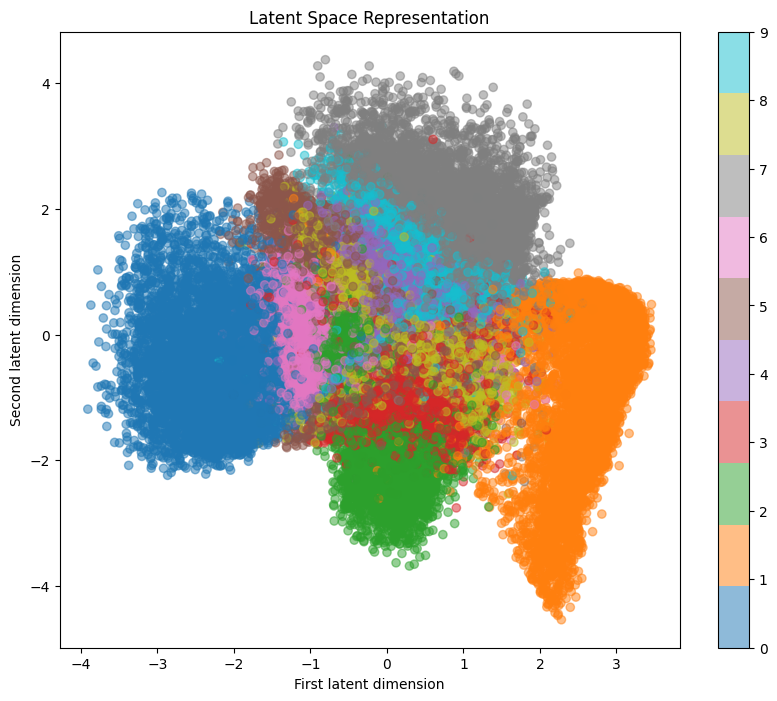

Plotting reconstructions...


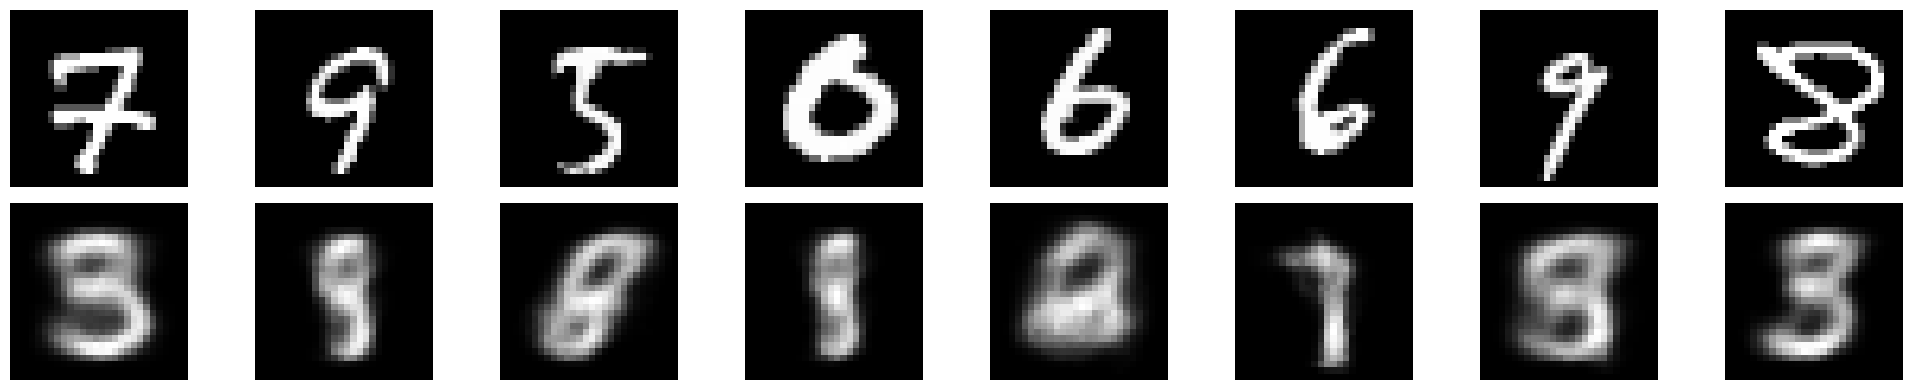

Plotting generated samples...


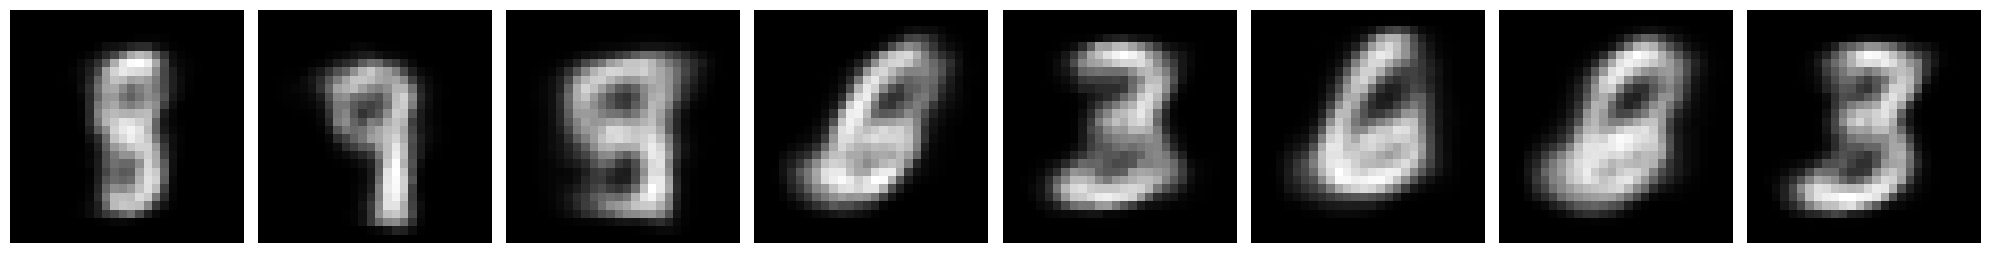

Plotting latent space traversal...


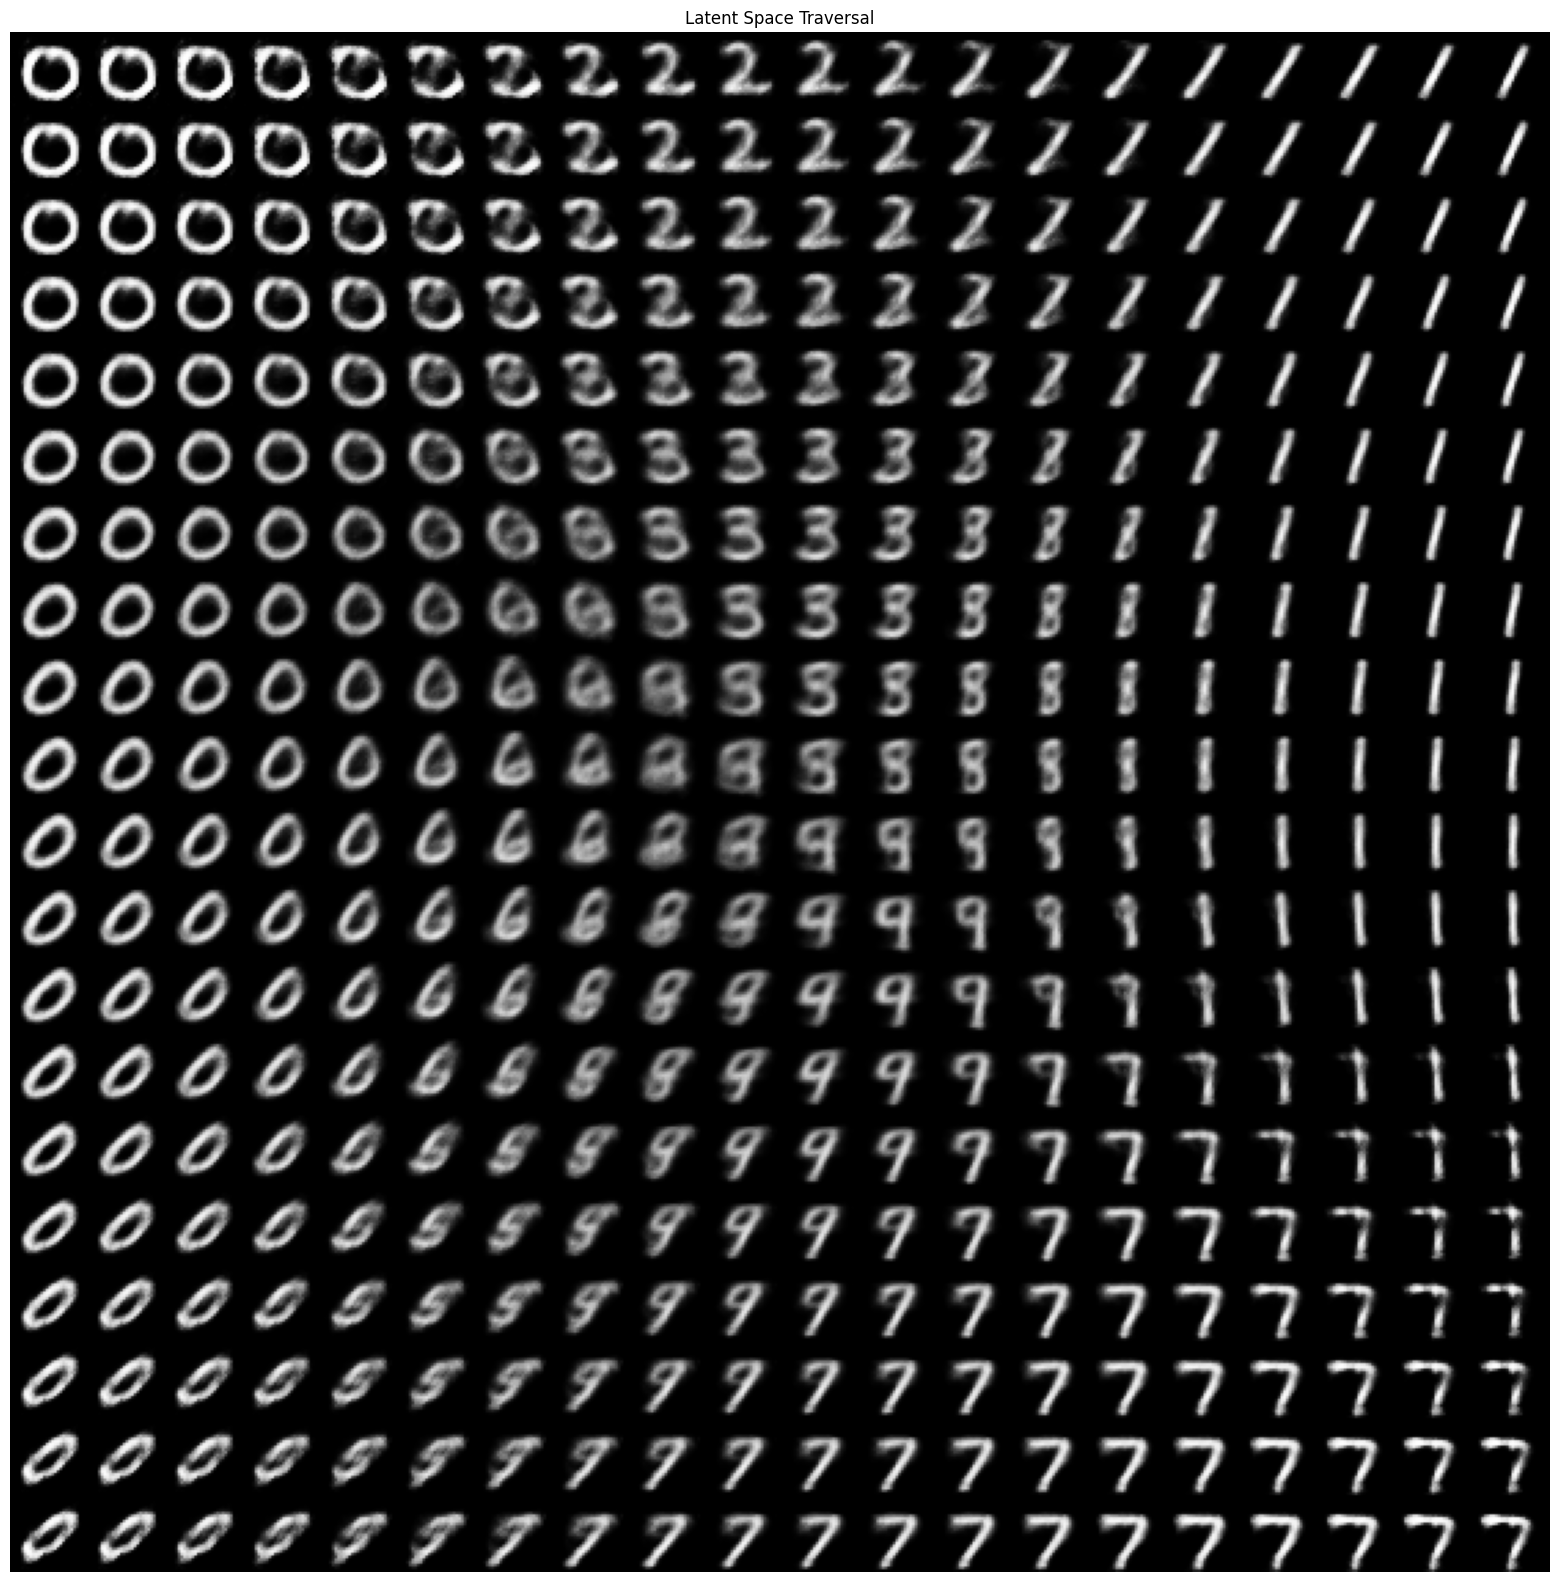

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

# Assuming the VAE, Encoder, and Decoder classes are defined as in your provided code
import torch
import os
from torch import nn

class Encoder(nn.Module):
    def __init__(self, z_dim, y_dim=0):
        super().__init__()
        self.z_dim = z_dim
        self.y_dim = y_dim
        self.net = nn.Sequential(
            nn.Linear(784 + y_dim, 300),
            nn.ELU(),
            nn.Linear(300, 300),
            nn.ELU(),
            nn.Linear(300, 2 * z_dim),
        )

    def forward(self, x, y=None):
        xy = x if y is None else torch.cat((x, y), dim=1)
        h = self.net(xy)
        m, v = gaussian_parameters(h, dim=1)
        return m, v

class Decoder(nn.Module):
    def __init__(self, z_dim, y_dim=0):
        super().__init__()
        self.z_dim = z_dim
        self.y_dim = y_dim
        self.net = nn.Sequential(
            nn.Linear(z_dim + y_dim, 300),
            nn.ELU(),
            nn.Linear(300, 300),
            nn.ELU(),
            nn.Linear(300, 784)
        )

    def forward(self, z, y=None):
        zy = z if y is None else torch.cat((z, y), dim=1)
        return self.net(zy)


# Define the VAE model (simplified version of the provided code)
class VAE(nn.Module):
    def __init__(self, z_dim=2):
        super().__init__()
        self.z_dim = z_dim
        self.enc = Encoder(self.z_dim)
        self.dec = Decoder(self.z_dim)
        self.z_prior_m = nn.Parameter(torch.zeros(1), requires_grad=False)
        self.z_prior_v = nn.Parameter(torch.ones(1), requires_grad=False)

    def negative_elbo_bound(self, x):
        m, v = self.enc(x)
        z = sample_gaussian(m, v)
        kl = kl_normal(m, v, self.z_prior_m.expand_as(m), self.z_prior_v.expand_as(v))
        kl = kl.mean()
        logits = self.dec(z)
        rec = F.binary_cross_entropy_with_logits(logits, x, reduction='none').sum(dim=1).mean()
        nelbo = kl + rec
        return nelbo, kl, rec

    def sample_sigmoid(self, batch):
        z = self.sample_z(batch)
        return self.compute_sigmoid_given(z)

    def compute_sigmoid_given(self, z):
        logits = self.dec(z)
        return torch.sigmoid(logits)

    def sample_z(self, batch):
        return sample_gaussian(
            self.z_prior_m.expand(batch, self.z_dim),
            self.z_prior_v.expand(batch, self.z_dim))

    def sample_x(self, batch):
        z = self.sample_z(batch)
        return torch.bernoulli(self.compute_sigmoid_given(z))

# Utility functions
def sample_gaussian(m, v):
    return m + torch.sqrt(v) * torch.randn_like(v)

def kl_normal(qm, qv, pm, pv):
    element_wise = 0.5 * (torch.log(pv) - torch.log(qv) + qv / pv + (qm - pm).pow(2) / pv - 1)
    return element_wise.sum(-1)

# Load MNIST dataset
def load_mnist(batch_size=128):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(-1))
    ])
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    return train_loader

# Train the model
def train_model(model, train_loader, epochs=10):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(train_loader):
            optimizer.zero_grad()
            loss, _, _ = model.negative_elbo_bound(data)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

# Visualization functions
def plot_latent_space(model, loader):
    model.eval()
    z_list = []
    labels_list = []
    with torch.no_grad():
        for x, y in loader:
            m, _ = model.enc(x)
            z_list.append(m)
            labels_list.append(y)
    z = torch.cat(z_list, dim=0)
    labels = torch.cat(labels_list, dim=0)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(z[:, 0], z[:, 1], c=labels, cmap='tab10', alpha=0.5)
    plt.colorbar(scatter)
    plt.title("Latent Space Representation")
    plt.xlabel("First latent dimension")
    plt.ylabel("Second latent dimension")
    plt.show()

def plot_reconstructions(model, loader):
    model.eval()
    x, _ = next(iter(loader))
    with torch.no_grad():
        x_recon = model.sample_sigmoid(x.size(0))
    n = min(x.size(0), 8)
    comparison = torch.cat([x[:n], x_recon[:n]])
    plt.figure(figsize=(20, 4))
    for i in range(n*2):
        plt.subplot(2, n, i+1)
        plt.imshow(comparison[i].view(28, 28).cpu(), cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_generations(model, n=8):
    model.eval()
    with torch.no_grad():
        sample = model.sample_sigmoid(n)
    plt.figure(figsize=(20, 4))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(sample[i].view(28, 28).cpu(), cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_latent_space_traversal(model):
    model.eval()
    # Create a grid of latent space points
    x = np.linspace(-3, 3, 20)
    y = np.linspace(-3, 3, 20)
    z_grid = np.dstack(np.meshgrid(x, y))

    # Generate images from the grid points
    imgs = []
    with torch.no_grad():
        for i in range(20):
            row = []
            for j in range(20):
                z = torch.FloatTensor(z_grid[i, j]).unsqueeze(0)
                img = model.compute_sigmoid_given(z)
                row.append(img.view(28, 28).cpu().numpy())
            imgs.append(np.hstack(row))

    # Plot the results
    plt.figure(figsize=(20, 20))
    plt.imshow(np.vstack(imgs), cmap='gray')
    plt.axis('off')
    plt.title("Latent Space Traversal")
    plt.show()

# Main execution
if __name__ == "__main__":
    z_dim = 2
    batch_size = 256
    epochs = 5

    train_loader = load_mnist(batch_size)
    model = VAE(z_dim=z_dim)

    print("Training the model...")
    train_model(model, train_loader, epochs)

    print("Plotting latent space...")
    plot_latent_space(model, train_loader)

    print("Plotting reconstructions...")
    plot_reconstructions(model, train_loader)

    print("Plotting generated samples...")
    plot_generations(model)

    print("Plotting latent space traversal...")
    plot_latent_space_traversal(model)